In [10]:
from numpy import random
import numpy as np
import os
import librosa 
import librosa.display
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
from sklearn import linear_model
%matplotlib inline
plt.style.use('ggplot')

plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 11
plt.rcParams['figure.titlesize'] = 13

In [11]:
def getLabel(filename, dict_label):
    '''
    Input: single filename
    Output: The label associated with the sound clip
    '''
    file_info = filename.split('.')[0]
    label = int(file_info.split('-')[1])
    return label

In [12]:
def one_hot_encode(labels):
    '''
    Input: label array 
    Output: encoded version of the label array
    '''
    n_labels = len(labels)
    n_unique_labels = 10
    one_hot_encode = np.zeros((n_labels,n_unique_labels))
    one_hot_encode[np.arange(n_labels), labels] = 1
    return one_hot_encode

In [13]:
def load_sound(file_names):
    '''
    Input: filenames in the current working directory
    Output: array storing float ndarrays associated with each wav file
    '''
    raw_sounds = []
    for name in file_names:
        Y, sr = librosa.load(name)
        raw_sounds.append(Y)
    return raw_sounds

In [14]:
def extract_feature(file_name):
    '''
    Input: file_name
    Output: stft, mfcc, chroma, mel, contrast, tonnetz features from the raw sound
    '''
    X, sample_rate = librosa.load(file_name)
    stft = np.abs(librosa.stft(X))
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
    return mfccs,chroma,mel,contrast,tonnetz

In [15]:
cwd = os.getcwd()
dir_sound = cwd + '/UrbanSound8K/Audio/fold'
# Build reference dict for the Urban Sound Taxonomy
dict_label = {
0: 'air_conditioner',
1: 'car_horn',
2: 'children_playing',
3: 'dog_bark',
4: 'drilling',
5: 'engine_idling',
6: 'gun_shot',
7: 'jackhammer',
8: 'siren',
9: 'street_music'
}

In [16]:
train_stat_dict = {}
test_stat_dict = {}
# Initialize a test and train status dictionary 
for i in range(0, 10):
    train_stat_dict[i] = 0
    test_stat_dict[i] = 0
print train_stat_dict
print test_stat_dict

{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}
{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}


In [17]:
arr = np.arange(10) + 1
np.random.shuffle(arr)
print arr

[ 9  1 10  8  4  7  3  5  2  6]


In [18]:
# 80% to 20% train test split
# trainging examples: 800
# test examples: 200
# Randomly chosen from 10 folders
tr_raw_features, tr_sound_labels = np.empty((0,193)), np.empty((0,10))
test_raw_features, test_sound_labels = np.empty((0,193)), np.empty((0,10))
for i in range(0, 10):
   print "Loading folder " + str(arr[i])
   cur_file_names = random.choice(os.listdir(dir_sound + str(arr[i]))[1:],100)
   new_file_names = ['UrbanSound8K/Audio/fold' + str(arr[i]) + '/' + name for name in cur_file_names]
   features, labels = np.empty((0,193)), np.empty((0, 10))
   if i <= 8:
      for fn in new_file_names:
          mfccs, chroma, mel, contrast,tonnetz = extract_feature(fn)
          ext_features = np.hstack([mfccs,chroma,mel,contrast,tonnetz])
          features = np.vstack([features,ext_features])
      tr_raw_features =  np.vstack([tr_raw_features,features])
      num_labels = [getLabel(name, dict_label) for name in cur_file_names]
      encoded_labels = one_hot_encode(num_labels)
      tr_sound_labels = np.vstack([tr_sound_labels, encoded_labels])
      for name in cur_file_names:
          train_stat_dict[getLabel(name, dict_label)] += 1
   else:
      for fn in new_file_names:
          mfccs, chroma, mel, contrast,tonnetz = extract_feature(fn)
          ext_features = np.hstack([mfccs,chroma,mel,contrast,tonnetz])
          features = np.vstack([features,ext_features])
      test_raw_features =  np.vstack([test_raw_features,features])
      num_labels = [getLabel(name, dict_label) for name in cur_file_names]
      encoded_labels = one_hot_encode(num_labels)
      test_sound_labels = np.vstack([test_sound_labels, encoded_labels])
      for name in cur_file_names:
          test_stat_dict[getLabel(name, dict_label)] += 1

Loading folder 9
Loading folder 1


/Users/guoyiwei/anaconda/lib/python2.7/site-packages/librosa/core/pitch.py:145: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')


Loading folder 10
Loading folder 8
Loading folder 4
Loading folder 7
Loading folder 3
Loading folder 5
Loading folder 2
Loading folder 6


In [19]:
# Test the status dictionary
print train_stat_dict
print test_stat_dict

{0: 105, 1: 41, 2: 105, 3: 100, 4: 104, 5: 115, 6: 28, 7: 101, 8: 101, 9: 100}
{0: 11, 1: 1, 2: 8, 3: 14, 4: 22, 5: 14, 6: 5, 7: 3, 8: 10, 9: 12}


In [20]:
def plot_waves(raw_sound):
    '''
    Input: the raw_sound array of a given audio clip
    Output: time series plot, specgram and Log amplitude plot
    '''
    plt.figure()
    i = 1
    while i <= 3:
        plt.subplot(3,1,i)
        if i == 1: librosa.display.waveplot(np.array(raw_sound),sr=22050)
        elif i == 2: specgram(np.array(raw_sound), Fs=22050)
        else: 
            S = np.abs(librosa.stft(raw_sound))
            librosa.display.specshow(librosa.power_to_db(S**2, ref=np.max),sr=22050, y_axis='log', x_axis='time')
            plt.colorbar(format='%+2.0f dB')
            plt.title('Log-Power spectrogram')
        plt.show()
        i += 1

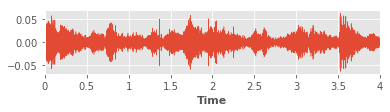

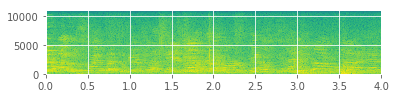

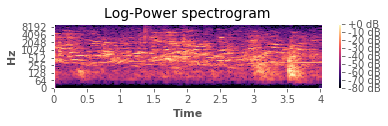

In [21]:
sample_file_name = 'UrbanSound8K/Audio/fold1/135776-2-0-65.wav'
X, sample_rate = librosa.load(sample_file_name)
# Plot of the wave given a raw sound clip
# Just for demonstration purposes
plot_waves(X)

In [22]:
from IPython.display import Markdown

Markdown("""
# Using Neural Network to train the examples
""")


# Using Neural Network to train the examples


In [23]:
# Sanity check
assert(tr_raw_features.shape[1] == 193)
assert(test_raw_features.shape[1] == 193)
assert(tr_sound_labels.shape[1] == 10)
assert(test_sound_labels.shape[1] == 10)

In [24]:
from sklearn.neural_network import MLPClassifier

In [ ]:
clf.predict([[2., 2.], [-1., -2.]])